In [1]:
import numpy as np
import sklearn

import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import metrics
from sklearn_extra.cluster import KMedoids

In [2]:
# Importamos los datos

X=np.load("./datos_mfcc_pca99_X.npy")
y=np.load("./datos_mfcc_pca99_y.npy")

In [3]:
#Reducimos el conjunto de entrenamiento al 50% usando un método no supervisado. En este caso, un C-means con el que pretendemos
# quedarnos con los centros de los clusters que aparezcan, que serán los puntos más representativos.

c = 6             # número de clases
nc = 120          # muestras por clase
n= 720           # número de muestras totales

X_reduc=[]
y_reduc=np.int16(np.kron(np.arange(c),np.ones(nc//2)))

for i in range(0,n,nc):
    k_means=KMeans(n_clusters=nc//2, random_state=0)
    k_means.fit(X[i:(i+nc)])
    centros=k_means.cluster_centers_
    X_reduc.append(centros)

In [4]:
print(X_reduc[0].shape)
# Reshapeamos las dimensiones de X_reduc para tenerlo todo en una matriz dónde cada fila será una muestra y cada columna una 
# característica. La matriz estará ordenada por clases. 
# Para reshapear, antes habrá que convertir a array.


X_reduc=np.array(X_reduc).reshape((360,464))
print(X_reduc.shape)

(60, 464)
(360, 464)


In [5]:
np.save("datos_mfcc_pca99_X_reducido_kmeans.npy",X_reduc)

In [350]:
# Ahora ya podemos dividir nuestro conjunto reducido en entrenamiento y test, y probar algunos métodos Kernel.

Xtr, Xts, ytr, yts = train_test_split(X_reduc, y_reduc, test_size=0.3, shuffle=True, random_state=0)

In [351]:
# Aplicamos un clasificador de tipo árbol de decisión. De momento, con los parámetros por defecto.

clf_tree = DecisionTreeClassifier(random_state=0)
clf_tree.fit(Xtr,ytr)

score_tr = clf_tree.score(Xtr,ytr)
score_ts = clf_tree.score(Xts,yts)
preds_train=clf_tree.predict(Xtr)
preds_test = clf_tree.predict(Xts)

print('')
print('OA train %0.2f' % score_tr)
print('Kappa train %0.2f' % metrics.cohen_kappa_score(ytr,preds_train))
print('OA test %0.2f' % score_ts)
print('Kappa test %0.2f' % metrics.cohen_kappa_score(yts,preds_test))


OA train 1.00
Kappa train 1.00
OA test 0.47
Kappa test 0.37


In [352]:
clf_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 0,
 'splitter': 'best'}

Los resultados parecen sospechosos. Tenemos mucho acierto en entrenamiento y poco en test, esto es un claro caso de overfitting. Esto seguramente se deba a que hemos dejado que el árbol crezca hasta que todos sus nodos son hojas, es decir,  que expandimos hasta que todos los nodos lleguen al mínimo de puntos definidos por defecto (=2).

Para solucionarlo, haremos un barrido de varios árboles variando la profundidad máxima y después pintaremos la típica gráfica de acierto en entrenamiento y test para ver a partir de qué momento empezamos a tener sobreajuste.

In [353]:
# Fijamos el random_state para que siempre que entremos en el bucle hagamos el mismo árbol.

depth=np.arange(1,12)
score2_tr=[]
score2_ts=[]
preds2_train=[]
preds2_test=[]



for i in depth:
    clf2_tree=DecisionTreeClassifier(criterion="gini",splitter="best",max_depth=i,random_state=0)
    clf2_tree.fit(Xtr,ytr)
    
    score2_tr.append(clf2_tree.score(Xtr,ytr))
    score2_ts.append(clf2_tree.score(Xts,yts))
    preds2_train.append(clf2_tree.predict(Xtr))
    preds2_test.append(clf2_tree.predict(Xts))


Text(0, 0.5, 'Accuracy')

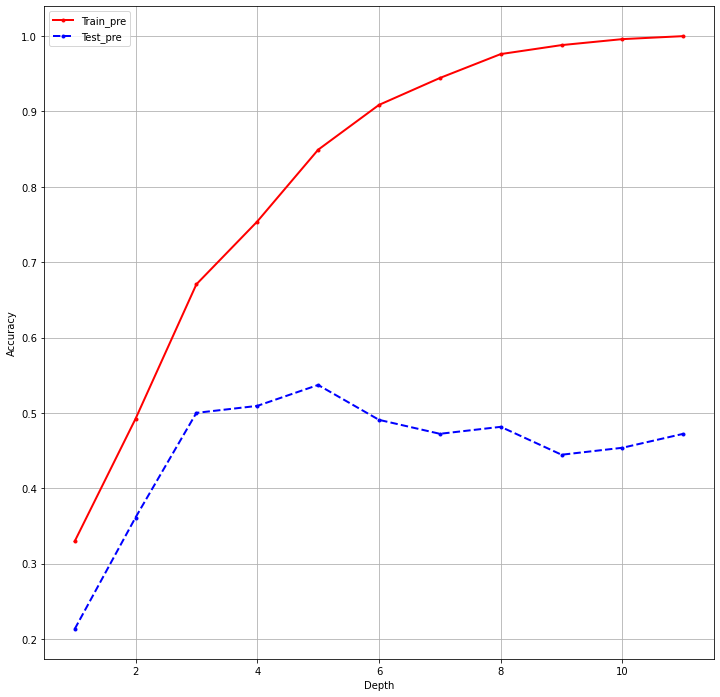

In [354]:
# Pintamos la evolución del acierto en entrenamiento y test, en función de la profundidad del árbol.

plt.figure(figsize=(12,12))
plt.plot(depth,score2_tr,".-r",label="Train_pre",linewidth=2)
plt.plot(depth,score2_ts,".--b",label="Test_pre",linewidth=2)
plt.legend()
plt.grid()
plt.xlabel("Depth")
plt.ylabel("Accuracy")

In [355]:
max(score2_ts)

0.5370370370370371

Obsevamos como con una profundidad de 5, tenemos el pico de acierto en test. A partir de ahí, el acierto baja para test y sigue subiendo para entrenamiento. Esto se conoce como sobre entrenamiento ("overfitting"), y vemos que si lo dejamos llegamos a obtener un acierto de 1 en entrenamiento, pero eso no nos interesa. 

Con los parámetros usados, deberíamos de quedarnos con el árbol de profundidad cinco.

También podemos probar a cambiar el criterio de división. En lugar de usar la impureza de gini, podemos usar la entropía y ver si mejoran mis resultados.

In [356]:
# Fijamos el random_state para que siempre que entremos en el bucle hagamos el mismo árbol.

depth=np.arange(1,12)
score3_tr=[]
score3_ts=[]
preds3_train=[]
preds3_test=[]


for i in depth:
    clf3_tree=DecisionTreeClassifier(criterion="entropy",splitter="best",max_depth=i,random_state=0)
    clf3_tree.fit(Xtr,ytr)
    
    score3_tr.append(clf3_tree.score(Xtr,ytr))
    score3_ts.append(clf3_tree.score(Xts,yts))
    preds3_train.append(clf3_tree.predict(Xtr))
    preds3_test.append(clf3_tree.predict(Xts))


Text(0, 0.5, 'Accuracy')

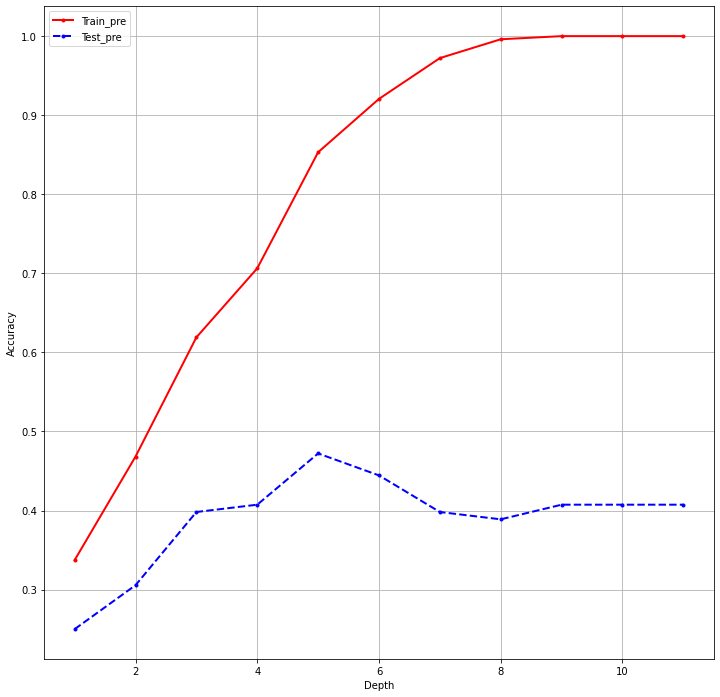

In [357]:
# Pintamos la evolución del acierto en entrenamiento y test, en función de la profundidad del árbol.

plt.figure(figsize=(12,12))
plt.plot(depth,score3_tr,".-r",label="Train_pre",linewidth=2)
plt.plot(depth,score3_ts,".--b",label="Test_pre",linewidth=2)
plt.legend()
plt.grid()
plt.xlabel("Depth")
plt.ylabel("Accuracy")

In [358]:
max(score3_ts)    # Rendimiento en test del mejor árbol.

0.4722222222222222

En este caso, con el criterio de entropía vemos que el máximo valor en test se alcanza también con una profundidad de cinco. Sin embargo, dicho valor es menor que cuando hacemos la división teniendo en cuenta el criterio de la impureza de Gini. 

Si tuvieramos que elegir entre los dos criterios de división, nos quedaríamos con el de la impureza de Gini por su sencillez en la estructura del árbol y porque tiene mejor rendimiento. 

Otra de las opciones que tenemos es aplicar algún método de poda para ver si mejoramos los resultados. En particular, usaremos el único método de poda que está implementado en `scikit-learn`.

In [359]:
# Para aplicar métodos de poda, lo que haremos será dejar crecer el árbol hasta el final y luego ir cortando hojas. 

clf4_tree=DecisionTreeClassifier(criterion="gini",splitter="best",max_depth=12,random_state=0)
clf4_tree.fit(Xtr,ytr)

# Una vez creado y entrenado el árbol, calculamos los parámetros para hacer la poda.

path = clf4_tree.cost_complexity_pruning_path(Xtr, ytr)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Ahora hacemos un bucle para ir aplicando la poda de abajo-arriba del árbol. Lo vamos podando de menos a más, ya que el último
# valor de ccp_alphas sería el que nos poda el árbol entero dejando un solo nodo.

clfs = []    # bolsa de árboles en la que vamos guardando árboles con diferentes níveles de poda.

for ccp_alpha in ccp_alphas:
    tree_aux = DecisionTreeClassifier(criterion="gini",splitter="best",random_state=0,ccp_alpha=ccp_alpha)
    tree_aux.fit(Xtr, ytr)
    clfs.append(tree_aux)
    
# Calculamos las métricas para cada uno de los árboles calculados para luego poder representarlas.

depth4 = [clf.tree_.max_depth for clf in clfs]
score4_tr = [clf.score(Xtr, ytr) for clf in clfs]
score4_ts = [clf.score(Xts, yts) for clf in clfs]

Text(0, 0.5, 'Accuracy')

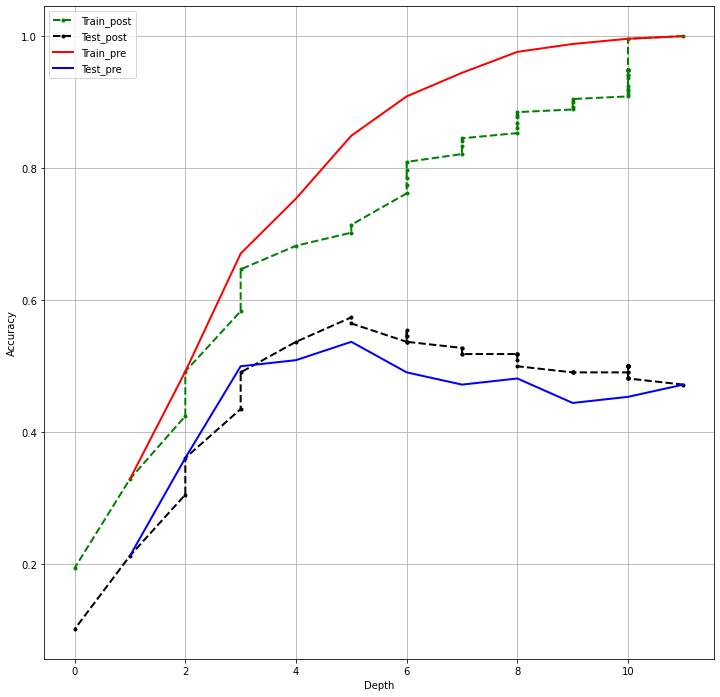

In [360]:
# Una vez hecha la poda a diferentes níveles, representamos los resultados de acierto en los árboles pre-poda y post-poda para
# ver si mejoramos.

#lo representamos todo
plt.figure(figsize=(12,12))
plt.plot(depth4,score4_tr,".--g",label="Train_post",linewidth=2)

plt.plot(depth4,score4_ts,".--k",label="Test_post",linewidth=2)

plt.plot(depth,score2_tr,"-r",label="Train_pre",linewidth=2)

plt.plot(depth,score2_ts,"-b",label="Test_pre",linewidth=2)
plt.legend()
plt.grid()
plt.xlabel("Depth")
plt.ylabel("Accuracy")

Viendo la gráfica a simple vista, parece que merece la pena aplicar poda ya que hay una mejoría en los resultados de acierto en test.

In [361]:
score4_ts.index(max(score4_ts))

37

In [362]:
max(score4_ts)

0.5740740740740741

In [363]:
score4_tr[37]

0.7023809523809523

In [364]:
max(score2_ts)

0.5370370370370371

In [365]:
clf4_tree=clfs[37]
clf4_tree.score(Xts,yts)

0.5740740740740741

En principio, decidimos quedarnos con el árbol de profundidad cinco tras realizar la poda, ya que nos mejora el acierto en test y lo balancea un poco más con el de entrenamiento. Esto ayuda a que no haya overfitting.



Ahora probamos a hacer poda utilizando el criterio de entropía como criterio de división.

In [366]:
# Para aplicar métodos de poda, lo que haremos será dejar crecer el árbol hasta el final y luego ir cortando hojas. 

clf5_tree=DecisionTreeClassifier(criterion="entropy",splitter="best",max_depth=12,random_state=0)
clf5_tree.fit(Xtr,ytr)

# Una vez creado y entrenado el árbol, calculamos los parámetros para hacer la poda.

path = clf5_tree.cost_complexity_pruning_path(Xtr, ytr)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Ahora hacemos un bucle para ir aplicando la poda de abajo-arriba del árbol. Lo vamos podando de menos a más, ya que el último
# valor de ccp_alphas sería el que nos poda el árbol entero dejando un solo nodo.

clfs = []    # bolsa de árboles en la que vamos guardando árboles con diferentes níveles de poda.

for ccp_alpha in ccp_alphas:
    tree_aux = DecisionTreeClassifier(criterion="entropy",splitter="best",random_state=0,ccp_alpha=ccp_alpha)
    tree_aux.fit(Xtr, ytr)
    clfs.append(tree_aux)
    
# Calculamos las métricas para cada uno de los árboles calculados para luego poder representarlas.

depth5 = [clf.tree_.max_depth for clf in clfs]
score5_tr = [clf.score(Xtr, ytr) for clf in clfs]
score5_ts = [clf.score(Xts, yts) for clf in clfs]

Text(0, 0.5, 'Accuracy')

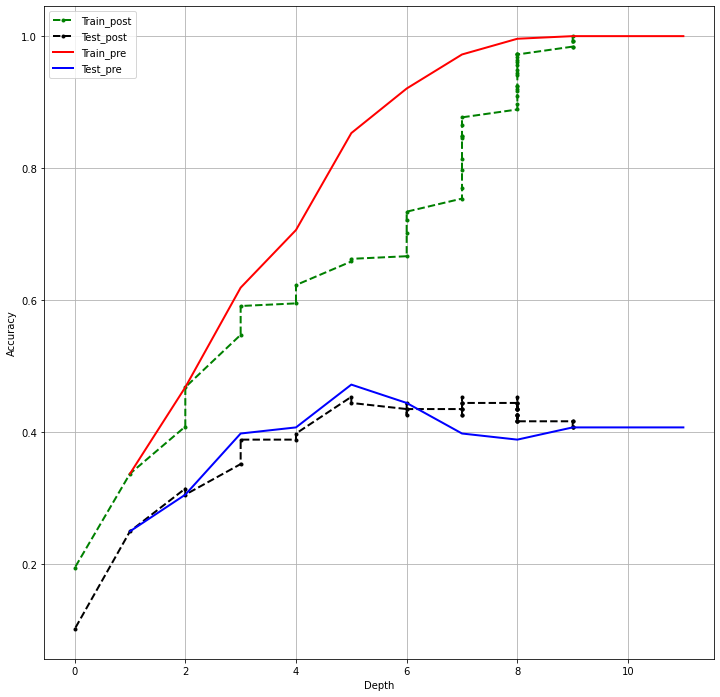

In [367]:
# Una vez hecha la poda a diferentes níveles, representamos los resultados de acierto en los árboles pre-poda y post-poda para
# ver si mejoramos.

#lo representamos todo
plt.figure(figsize=(12,12))
plt.plot(depth5,score5_tr,".--g",label="Train_post",linewidth=2)

plt.plot(depth5,score5_ts,".--k",label="Test_post",linewidth=2)

plt.plot(depth,score3_tr,"-r",label="Train_pre",linewidth=2)

plt.plot(depth,score3_ts,"-b",label="Test_pre",linewidth=2)
plt.legend()
plt.grid()
plt.xlabel("Depth")
plt.ylabel("Accuracy")

Con el criterio de entropía no parece que mejoremos los resultados que obteníamos con el criterio de la impureza de Gini. Por tanto nos quedamos con el resultado anterior.

Así, de aquí en adelante continuamos con el clasificador `clf4_tree`.

Finalemente, la función `DecisionTreeClassifier` trae implementado un método que nos permite ver la importancia de cada una de las características que estamos teniendo en cuenta a la hora de construir el árbol. 

Echar un vistazo a esa importancia nos puede permitir eliminar algunas características que tengan muy poca importancia. Al hacer esto es posible que los resultados mejoren.

In [368]:
importancias=clf4_tree.feature_importances_
print(importancias)

[0.38389873 0.26047705 0.         0.12949196 0.         0.16102301
 0.         0.         0.         0.         0.         0.06510926
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.    

Hemos obtenido la importancia de cada característica, también conocida como importancia de Gini. 

Vemos que hay muchas características con una importancia de cero. Una opción podría ser eliminar dichas características y volver a realizar el árbol para ver si mejoramos resultados. La alta dimensionalidad puede ser un problema.

In [369]:
indices=np.where(importancias!=0)


In [370]:
X_reduc2=X_reduc[:,indices]

In [371]:
print(X_reduc2.shape)
X_reduc2= X_reduc2.reshape((360,5))
print(X_reduc2.shape)
np.save("datos_mfcc_pca99_X_reducido_2kmeans.npy",X_reduc2)
np.save("datos_mfcc_pca99_y_reducido_kmeans.npy",y_reduc)

(360, 1, 5)
(360, 5)


In [372]:
# Ahora volvemos a dividir dividir nuestro conjunto reducido en entrenamiento y test, y probar algunos métodos Kernel.
# Fijamos el mismo random_state para que se construyan los mismos subconjuntos.

Xtr, Xts, ytr, yts = train_test_split(X_reduc2, y_reduc, test_size=0.3, shuffle=True, random_state=0)

In [373]:
Xtr.shape

(252, 5)

In [374]:
clf4_tree

DecisionTreeClassifier(ccp_alpha=0.023015873015873003, random_state=0)

In [375]:
# Fijamos el random_state para que siempre que entremos en el bucle hagamos el mismo árbol.


clf5_tree=DecisionTreeClassifier(ccp_alpha=0.023015873015873003, random_state=0)
clf5_tree.fit(Xtr,ytr)

score_tr_final=clf5_tree.score(Xtr,ytr)
score_ts_final=clf5_tree.score(Xts,yts)


In [376]:
score_ts_final

0.5740740740740741

In [377]:
score_tr_final

0.7023809523809523

Hemos eliminado la gran mayoría de las característica, dejando solo cinco de ellas, y vemos como el acierto en test y en entrenamiento se mantienen igual. Esto es una buena noticia ya que hemos eliminado un montón de características que no estaban aportando nada y esto nos permite reducir la dimensionalidad.

In [382]:
clf5_tree.feature_importances_

array([0.38389873, 0.26047705, 0.12949196, 0.16102301, 0.06510926])

In [383]:
# Fijamos el random_state para que siempre que entremos en el bucle hagamos el mismo árbol.


clf6_tree=DecisionTreeClassifier(criterion='entropy', ccp_alpha=0.023015873015873003, random_state=0)
clf6_tree.fit(Xtr,ytr)

score_tr_final=clf6_tree.score(Xtr,ytr)
score_ts_final=clf6_tree.score(Xts,yts)


In [384]:
score_ts_final

0.5925925925925926

In [385]:
score_tr_final

0.8214285714285714

Con el criterio de entropía, incluso mejoran más los resultados.